## 자산 배분 포트폴리오 최적화 및 Efficient Frontier
- 다양한 포트폴리오를 생성하고, 각 포트폴리오의 샤프비율, 수익률, 변동성을 분석
- Efficient Frontier를 시각화하여 최적의 포트폴리오 구성을 제안
- 고객 투자 성향 맞춤 포트폴리오 제공
- 개별 자산의 변동성과 수익률을 포트폴리오와 비교

### 작성자
- 작성자: 신동규
- 작성일: 2024-09-05
- 프로젝트 버전: 2.0

### 참고 자료
- [https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb]

### 수정 내역

수정 할 내역
- efficient frontier 구현
- interactive plot 시각화

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

np.random.seed(777)


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트를 설정합니다.
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 경우
# plt.rcParams['font.family'] = 'AppleGothic'  # 맥OS의 경우
# plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스의 경우

# 그래프에서 마이너스 기호(-)가 깨지는 문제 해결
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 금융 데이터 다운로드
# stocks  = ['IGLB', 'HYG', 'SPY', 'MBB', 'BOTZ', 'ICLN', 'PAVE']
stocks  = ['IGLB', 'HYG', 'SPY', 'MBB', 'HYDR', 'WCLD', 'PAVE']     # 새로 사용할 자산군
data = yf.download(stocks, start="2017-04-01")['Adj Close']
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()      
num_portfolios = 25000         
# 무위험 이자율 (미국 10년물 채권)
# 미국 10년물 국채 수익률 데이터를 가져오기
tnx_data = yf.download('^TNX', period='1d')['Adj Close']
risk_free_rate = tnx_data.iloc[-1] / 100 


[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data

Ticker,HYDR,HYG,IGLB,MBB,PAVE,SPY,WCLD
Date,,,,,,,
2017-04-03 00:00:00+00:00,NaN,59.242325,43.915096,88.633629,13.961949,207.720215,NaN
2017-04-04 00:00:00+00:00,NaN,59.262661,43.870747,88.583763,13.948582,207.852661,NaN
2017-04-05 00:00:00+00:00,NaN,59.215195,43.922501,88.708458,13.843563,207.234802,NaN
2017-04-06 00:00:00+00:00,NaN,59.289806,43.944668,88.625313,13.948582,207.817368,NaN
2017-04-07 00:00:00+00:00,NaN,59.262661,43.752457,88.434113,14.005866,207.605545,NaN
...,...,...,...,...,...,...,...
2024-09-16 00:00:00+00:00,23.840000,79.830002,54.189999,96.660004,39.090000,561.118896,31.200001
2024-09-17 00:00:00+00:00,24.309999,79.849998,54.200001,96.610001,39.529999,561.348206,31.260000
2024-09-18 00:00:00+00:00,24.320000,79.919998,53.830002,96.169998,39.560001,559.683350,31.150000


In [5]:
# 포트폴리오 수익률 계산 함수
def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights) * 252

# 포트폴리오 변동성 계산 함수
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

# 포트폴리오의 연간 성과 계산 함수
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = portfolio_return(weights, mean_returns)
    std = portfolio_volatility(weights, cov_matrix)
    return std, returns

# HHI 계산 함수
def calculate_hhi(weights):
    return np.sum(weights ** 2) * 10000

# 효율적 프론티어 상에서 변동성에 따른 포트폴리오를 계산하는 함수 (HHI 조건 포함)
def get_efficient_portfolio(mean_returns, cov_matrix, target_volatility, max_hhi=2000, tol=1e-10):
    num_assets = len(mean_returns)
    
    def objective(weights):
        return -portfolio_return(weights, mean_returns)
    
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # 모든 가중치의 합이 1이어야 함
        {'type': 'eq', 'fun': lambda x: portfolio_volatility(x, cov_matrix) - target_volatility},  # 변동성이 목표 변동성과 같아야 함
        {'type': 'ineq', 'fun': lambda x: max_hhi - calculate_hhi(x)},  # HHI 조건을 만족해야 함
        {'type': 'ineq', 'fun': lambda x: x - 0.05}  # 각 자산의 최소 비율 5%
    )
    
    bounds = tuple((0, 1) for asset in range(num_assets))  # 각 자산의 가중치는 0과 1 사이
    
    # 최적화 알고리즘 실행
    result = minimize(objective, num_assets * [1. / num_assets],
                      method='SLSQP', bounds=bounds, constraints=constraints,
                      options={'ftol': tol})  # 허용 오차(tolerance)를 줄임
    
    return result

# 랜덤 포트폴리오 생성 및 샤프 지수 계산 (HHI < 2000 조건)
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = []
    weights_record = []
    for i in range(num_portfolios):
        while True:
            weights = np.random.random(len(stocks))  # 임의의 비율 생성
            weights /= np.sum(weights)  # 비율의 합이 1이 되도록
            hhi = calculate_hhi(weights)
            if hhi < 2000:  # HHI < 2000 조건
                break
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev  # 샤프 지수
        results.append([portfolio_std_dev, portfolio_return, sharpe_ratio])
        weights_record.append(weights)
    return np.array(results), np.array(weights_record)

In [6]:
# 포트폴리오 최적화 및 시뮬레이션 시각화
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # 샤프 지수가 가장 높은 포트폴리오 [공격적]
    max_sharpe_idx = np.argmax(results[:, 2])
    sdp, rp = results[max_sharpe_idx, 0], results[max_sharpe_idx, 1]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stocks, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # 변동성이 가장 낮은 포트폴리오 [보수적]
    min_vol_idx = np.argmin(results[:, 0])
    sdp_min, rp_min = results[min_vol_idx, 0], results[min_vol_idx, 1]
    # 해당 변동성에서 가장 높은 수익을 제공하는 포트폴리오 선택
    min_vol_result = get_efficient_portfolio(mean_returns, cov_matrix, sdp_min)
    min_vol_allocation = pd.DataFrame(min_vol_result.x, index=stocks, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # 중간 변동성 계산 및 해당 변동성에 대한 효율적 포트폴리오 계산 (HHI 조건 포함)
    mid_volatility = (sdp + sdp_min) / 2
    mid_result = get_efficient_portfolio(mean_returns, cov_matrix, mid_volatility)
    mid_allocation = pd.DataFrame(mid_result.x, index=stocks, columns=['allocation'])
    mid_allocation.allocation = [round(i * 100, 2) for i in mid_allocation.allocation]
    mid_allocation = mid_allocation.T
    sdp_mid = portfolio_volatility(mid_result.x, cov_matrix)
    rp_mid = portfolio_return(mid_result.x, mean_returns)

    # 성과와 자산 배분 비율을 출력
    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation (on Efficient Frontier)\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)
    print("-" * 80)
    print("Mid-point Portfolio Allocation (on Efficient Frontier)\n")
    print("Annualised Return:", round(rp_mid, 2))
    print("Annualised Volatility:", round(sdp_mid, 2))
    print("\n")
    print(mid_allocation)
    
    # 시각화
    plt.figure(figsize=(10, 7))
    plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.scatter(sdp_mid, rp_mid, marker='*', color='b', s=500, label='Mid-point portfolio')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier with HHI constraint')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # 각 포트폴리오 가중치를 반환
    return weights[max_sharpe_idx], min_vol_result.x, mid_result.x

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.1
Annualised Volatility: 0.14


            IGLB   HYG    SPY    MBB   HYDR   WCLD  PAVE
allocation  0.25  9.08  18.38  15.15  20.43  29.35  7.35
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation (on Efficient Frontier)

Annualised Return: 0.04
Annualised Volatility: 0.11


            IGLB    HYG    SPY    MBB  HYDR   WCLD  PAVE
allocation   5.0  22.69  20.43  29.91  6.33  10.64   5.0
--------------------------------------------------------------------------------
Mid-point Portfolio Allocation (on Efficient Frontier)

Annualised Return: 0.06
Annualised Volatility: 0.12


            IGLB    HYG    SPY    MBB   HYDR   WCLD  PAVE
allocation   5.0  12.36  10.53  30.32  11.68  25.11   5.0


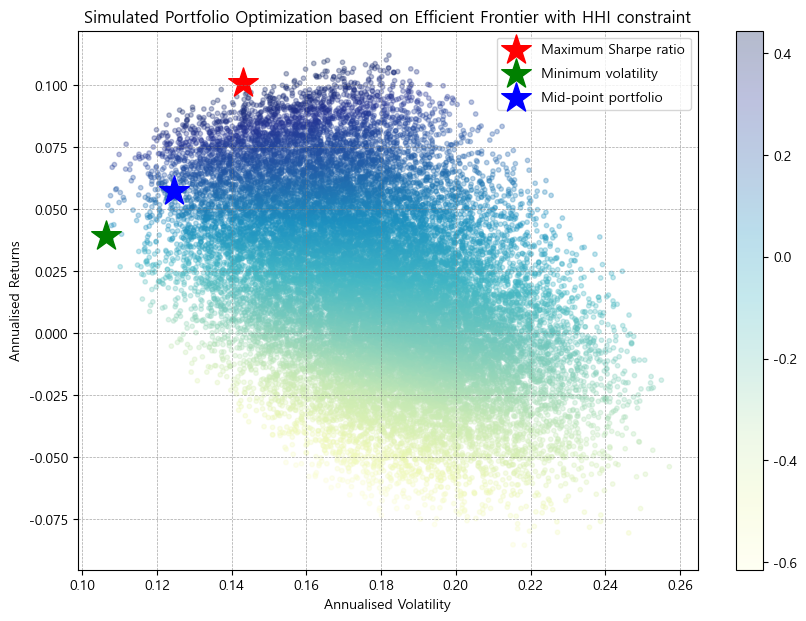

(array([0.00250667, 0.09083499, 0.18380966, 0.15154795, 0.20425018,
        0.29351773, 0.07353282]),
 array([0.05      , 0.22688646, 0.20428961, 0.29910841, 0.06329154,
        0.10642398, 0.05      ]),
 array([0.05      , 0.12356934, 0.10530014, 0.30323733, 0.11680153,
        0.25109166, 0.05      ]))

In [7]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

#### 개별 자산과 비교

In [8]:
# mean_returns와 cov_matrix를 stocks 순서로 정렬
mean_returns = returns.mean().reindex(stocks)
cov_matrix = returns.cov().reindex(index=stocks, columns=stocks)

# 개별 자산의 변동성과 수익률 계산
individual_volatility = np.sqrt(np.diag(cov_matrix)) * np.sqrt(252)
individual_returns = mean_returns * 252

In [9]:
# 포트폴리오 최적화 및 시뮬레이션 시각화
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # 샤프 지수가 가장 높은 포트폴리오 [공격적]
    max_sharpe_idx = np.argmax(results[:, 2])
    sdp, rp = results[max_sharpe_idx, 0], results[max_sharpe_idx, 1]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stocks, columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i * 100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # 변동성이 가장 낮은 포트폴리오 [보수적]
    min_vol_idx = np.argmin(results[:, 0])
    sdp_min, rp_min = results[min_vol_idx, 0], results[min_vol_idx, 1]
    # 해당 변동성에서 가장 높은 수익을 제공하는 포트폴리오 선택
    min_vol_result = get_efficient_portfolio(mean_returns, cov_matrix, sdp_min)
    min_vol_allocation = pd.DataFrame(min_vol_result.x, index=stocks, columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 2) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    # 중간 변동성 계산 및 해당 변동성에 대한 효율적 포트폴리오 계산 (HHI 조건 포함)
    mid_volatility = (sdp + sdp_min) / 2
    mid_result = get_efficient_portfolio(mean_returns, cov_matrix, mid_volatility)
    mid_allocation = pd.DataFrame(mid_result.x, index=stocks, columns=['allocation'])
    mid_allocation.allocation = [round(i * 100, 2) for i in mid_allocation.allocation]
    mid_allocation = mid_allocation.T
    sdp_mid = portfolio_volatility(mid_result.x, cov_matrix)
    rp_mid = portfolio_return(mid_result.x, mean_returns)

    # 성과와 자산 배분 비율을 출력
    print("-" * 80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp, 2))
    print("Annualised Volatility:", round(sdp, 2))
    print("\n")
    print(max_sharpe_allocation)
    print("-" * 80)
    print("Minimum Volatility Portfolio Allocation (on Efficient Frontier)\n")
    print("Annualised Return:", round(rp_min, 2))
    print("Annualised Volatility:", round(sdp_min, 2))
    print("\n")
    print(min_vol_allocation)
    print("-" * 80)
    print("Mid-point Portfolio Allocation (on Efficient Frontier)\n")
    print("Annualised Return:", round(rp_mid, 2))
    print("Annualised Volatility:", round(sdp_mid, 2))
    print("\n")
    print(mid_allocation)
    
    # 시각화
    plt.figure(figsize=(10, 7))
    plt.scatter(results[:, 0], results[:, 1], c=results[:, 2], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp, rp, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.scatter(sdp_mid, rp_mid, marker='*', color='b', s=500, label='Mid-point portfolio')

    # 개별 자산의 변동성과 수익률 표시
    plt.scatter(individual_volatility, individual_returns, marker='o', color='black', s=100, label='Individual Assets')

    # 각 개별 자산의 이름 표시
    for i, txt in enumerate(stocks):
        plt.annotate(txt, (individual_volatility[i], individual_returns[i]), fontsize=7, xytext=(10,0), textcoords='offset points')

    plt.title('Simulated Portfolio Optimization with Individual Assets')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.16


             IGLB   HYG    SPY    MBB  HYDR   WCLD   PAVE
allocation  11.22  7.53  21.84  17.85   0.2  13.02  28.36
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation (on Efficient Frontier)

Annualised Return: 0.06
Annualised Volatility: 0.11


             IGLB    HYG    SPY    MBB  HYDR  WCLD  PAVE
allocation  20.43  22.69  10.64  29.92   5.0   5.0  6.32
--------------------------------------------------------------------------------
Mid-point Portfolio Allocation (on Efficient Frontier)

Annualised Return: 0.07
Annualised Volatility: 0.13


             IGLB  HYG    SPY    MBB  HYDR  WCLD   PAVE
allocation  10.49  9.9  28.55  27.01   5.0   5.0  14.06


C:\Users\user\AppData\Local\Temp\ipykernel_28204\1906787135.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (individual_volatility[i], individual_returns[i]), fontsize=7, xytext=(10,0), textcoords='offset points')


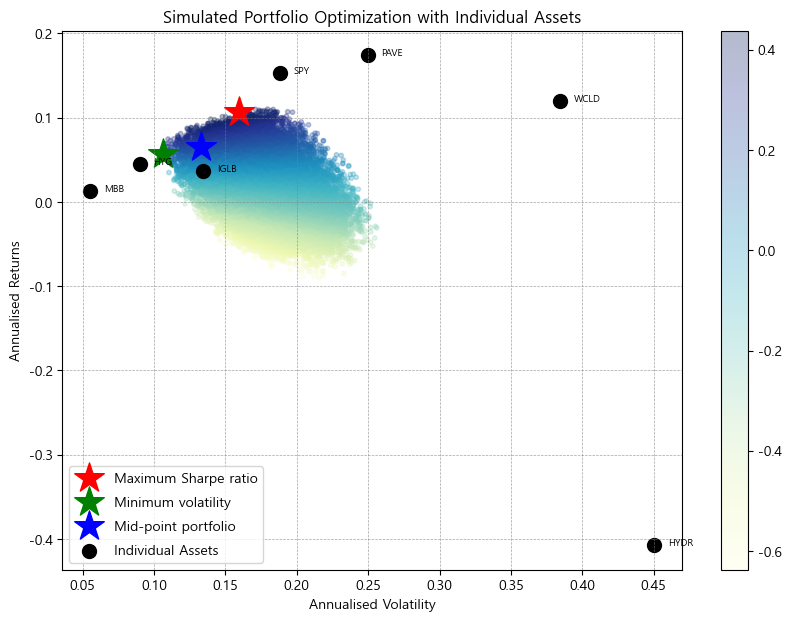

In [14]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


In [51]:
# import matplotlib.pyplot as plt
# import numpy as np

# # 자산 이름
# assets = ['BOTZ', 'HYG', 'ICLN', 'IGLB', 'MBB', 'PAVE', 'SPY']

# # 계산된 변동성 및 수익률 (위의 결과를 직접 사용)
# v = np.array([0.28348324, 0.09019814, 0.24987331, 0.13489489, 0.05562329, 0.26381324, 0.18841445])
# r = np.array([0.113408, 0.042864, 0.123188, 0.034155, 0.011759, 0.165572, 0.149113])

# # 시각화
# plt.figure(figsize=(10, 7))
# plt.scatter(v, r, marker='o', color='blue', s=100)

# # 각 자산의 이름을 점 위에 표시
# for i, asset in enumerate(assets):
#     plt.annotate(asset, (v[i], r[i]), fontsize=12, xytext=(5, 5), textcoords='offset points')

# plt.title('Verified Volatility vs. Return for Selected Assets')
# plt.xlabel('Annualised Volatility')
# plt.ylabel('Annualised Return')
# plt.grid(True)
# plt.show()


## 벤치마크와 비교

In [77]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)

    # 샤프 지수가 가장 높은 포트폴리오 [공격적]
    max_sharpe_idx = np.argmax(results[:, 2])
    max_sharpe_allocation = weights[max_sharpe_idx]
    
    # 변동성이 가장 낮은 포트폴리오 [보수적]
    min_vol_idx = np.argmin(results[:, 0])
    min_vol_result = get_efficient_portfolio(mean_returns, cov_matrix, results[min_vol_idx, 0])
    min_vol_allocation = min_vol_result.x
    
    # 중간 변동성 계산 및 해당 변동성에 대한 효율적 포트폴리오 계산 [중간]
    mid_volatility = (results[max_sharpe_idx, 0] + results[min_vol_idx, 0]) / 2
    mid_result = get_efficient_portfolio(mean_returns, cov_matrix, mid_volatility)
    mid_allocation = mid_result.x

    # 가중치를 반환하도록 설정
    return max_sharpe_allocation, min_vol_allocation, mid_allocation


In [78]:
# 기존의 포트폴리오 자산 리스트 (로보틱스와 친환경 자산 제외)
benchmark_stocks = ['IGLB', 'HYG', 'SPY', 'MBB', 'PAVE']

# 기존 포트폴리오의 전체 자산 리스트
portfolio_stocks = ['IGLB', 'HYG', 'SPY', 'MBB', 'BOTZ', 'ICLN', 'PAVE']

# 금융 데이터 다운로드
benchmark_data = yf.download(benchmark_stocks, start="2017-04-01")['Adj Close']
portfolio_data = yf.download(portfolio_stocks, start="2017-04-01")['Adj Close']

# 수익률 계산
benchmark_returns = benchmark_data.pct_change().dropna()
portfolio_returns = portfolio_data.pct_change().dropna()

# 벤치마크 가중치 설정 (동일 가중치)
benchmark_weights = np.array([1/len(benchmark_stocks)] * len(benchmark_stocks))

# display_simulated_ef_with_random 함수의 결과로 각 포트폴리오의 가중치를 가져오는 부분
mean_returns = portfolio_returns.mean()
cov_matrix = portfolio_returns.cov()
num_portfolios = 25000


[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  7 of 7 completed


In [79]:
max_sharpe_weights, min_vol_weights, mid_weights = display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)


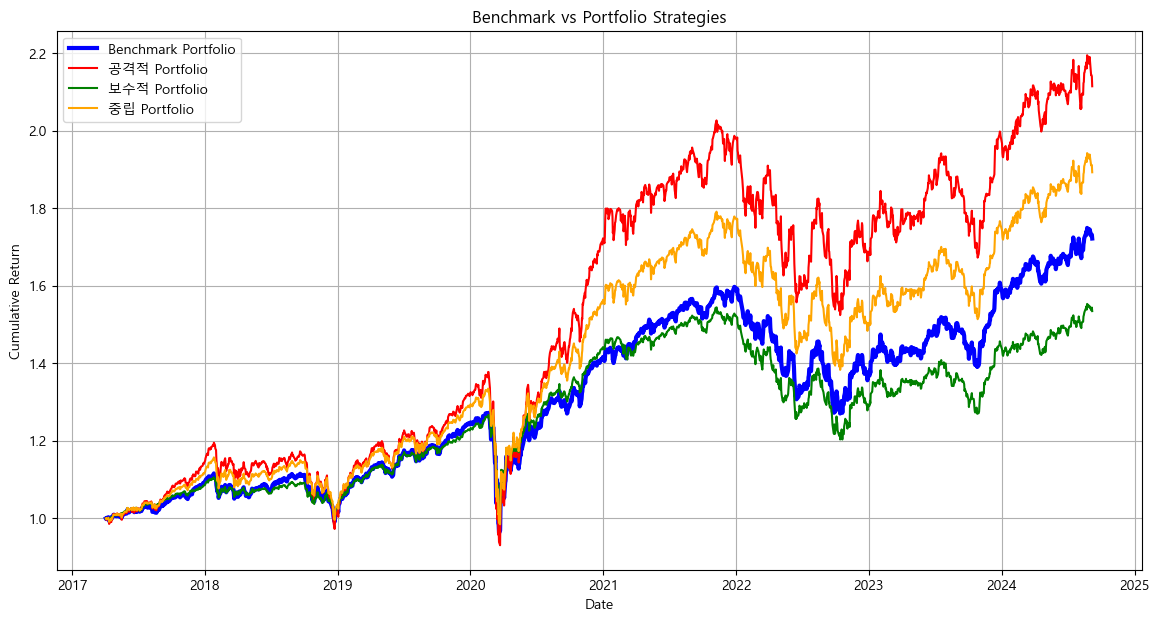

In [80]:
# 포트폴리오 수익률 계산
benchmark_portfolio_returns = benchmark_returns.dot(benchmark_weights)
aggressive_portfolio_returns = portfolio_returns.dot(max_sharpe_weights)
conservative_portfolio_returns = portfolio_returns.dot(min_vol_weights)
moderate_portfolio_returns = portfolio_returns.dot(mid_weights)

# 누적 수익률 계산
benchmark_cumulative_return = (1 + benchmark_portfolio_returns).cumprod()
aggressive_cumulative_return = (1 + aggressive_portfolio_returns).cumprod()
conservative_cumulative_return = (1 + conservative_portfolio_returns).cumprod()
moderate_cumulative_return = (1 + moderate_portfolio_returns).cumprod()

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(benchmark_cumulative_return, label='Benchmark Portfolio', color='blue', lw=3 , ls='-')
plt.plot(aggressive_cumulative_return, label='공격적 Portfolio', color='red')
plt.plot(conservative_cumulative_return, label='보수적 Portfolio', color='green')
plt.plot(moderate_cumulative_return, label='중립 Portfolio', color='orange')
plt.title('Benchmark vs Portfolio Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  7 of 7 completed


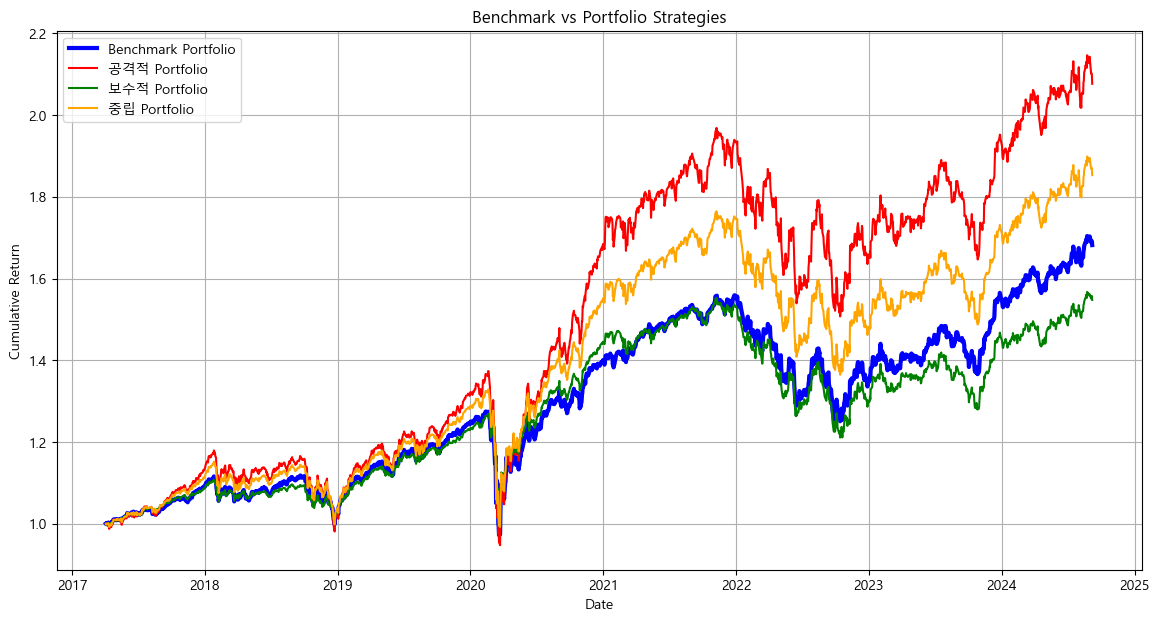

In [81]:

# 확장된 벤치마크 자산 리스트 (기존 5개 자산 섹터에 대하여)
benchmark_stocks = [
    'IGLB', 'LQD',  # 회사채
    'HYG', 'JNK',   # 하이일드
    'SPY', 'VOO',   # S&P 500 인덱스
    'MBB', 'VMBS',  # 주택저당증권(MBS)
    'PAVE', 'XLI'   # 인프라, 산업 섹터
]

# 금융 데이터 다운로드
benchmark_data = yf.download(benchmark_stocks, start="2017-04-01")['Adj Close']
portfolio_data = yf.download(portfolio_stocks, start="2017-04-01")['Adj Close']

# 수익률 계산
benchmark_returns = benchmark_data.pct_change().dropna()
portfolio_returns = portfolio_data.pct_change().dropna()

# 벤치마크 가중치 설정 (동일 가중치)
benchmark_weights = np.array([1/len(benchmark_stocks)] * len(benchmark_stocks))

# display_simulated_ef_with_random 함수의 결과로 각 포트폴리오의 가중치를 가져오는 부분
mean_returns = portfolio_returns.mean()
cov_matrix = portfolio_returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0381

# 여기서 실제 함수를 호출하여 결과를 가져옵니다.
max_sharpe_weights, min_vol_weights, mid_weights = display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# 포트폴리오 수익률 계산
benchmark_portfolio_returns = benchmark_returns.dot(benchmark_weights)
aggressive_portfolio_returns = portfolio_returns.dot(max_sharpe_weights)
conservative_portfolio_returns = portfolio_returns.dot(min_vol_weights)
moderate_portfolio_returns = portfolio_returns.dot(mid_weights)

# 누적 수익률 계산
benchmark_cumulative_return = (1 + benchmark_portfolio_returns).cumprod()
aggressive_cumulative_return = (1 + aggressive_portfolio_returns).cumprod()
conservative_cumulative_return = (1 + conservative_portfolio_returns).cumprod()
moderate_cumulative_return = (1 + moderate_portfolio_returns).cumprod()

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(benchmark_cumulative_return, label='Benchmark Portfolio', color='blue', lw=3 , ls='-')
plt.plot(aggressive_cumulative_return, label='공격적 Portfolio', color='red')
plt.plot(conservative_cumulative_return, label='보수적 Portfolio', color='green')
plt.plot(moderate_cumulative_return, label='중립 Portfolio', color='orange')
plt.title('Benchmark vs Portfolio Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

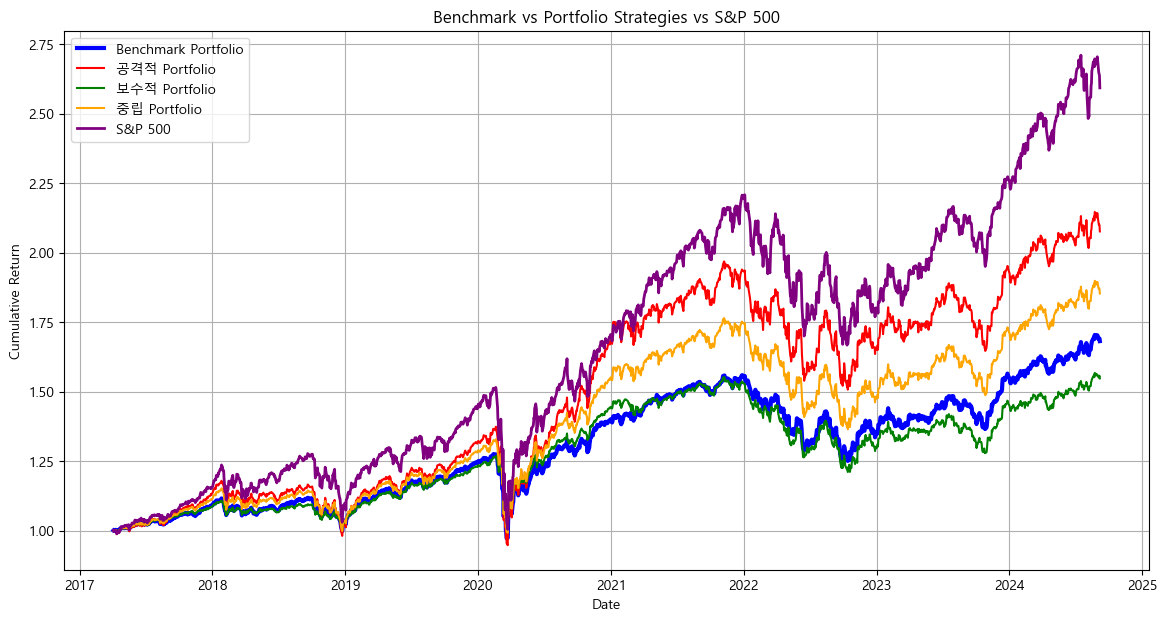

In [82]:
sp500_returns = portfolio_returns['SPY']

# S&P 500 누적 수익률 계산
sp500_cumulative_return = (1 + sp500_returns).cumprod()

# 기존 그래프에 S&P 500 누적 수익률 추가
plt.figure(figsize=(14, 7))
plt.plot(benchmark_cumulative_return, label='Benchmark Portfolio', color='blue', lw=3 , ls='-')
plt.plot(aggressive_cumulative_return, label='공격적 Portfolio', color='red')
plt.plot(conservative_cumulative_return, label='보수적 Portfolio', color='green')
plt.plot(moderate_cumulative_return, label='중립 Portfolio', color='orange')
plt.plot(sp500_cumulative_return, label='S&P 500', color='purple', lw=2, ls='-')
plt.title('Benchmark vs Portfolio Strategies vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


### 리포트

In [83]:
import quantstats as qs

def generate_quantstats_report(weights, returns, risk_free_rate, report_name):
    portfolio_returns = pd.Series(np.dot(returns, weights), index=returns.index)
    qs.reports.html(portfolio_returns, rf=risk_free_rate, output=f"{report_name}.html")



In [84]:
# 공격적 포트폴리오 보고서 생성
generate_quantstats_report(max_sharpe_weights, returns, risk_free_rate, 'aggressive_portfolio')

# 보수적 포트폴리오 보고서 생성
generate_quantstats_report(min_vol_weights, returns, risk_free_rate, 'conservative_portfolio')

# 중간 포트폴리오 보고서 생성
generate_quantstats_report(mid_weights, returns, risk_free_rate, 'mid_point_portfolio')


c:\Users\user\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\user\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\user\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **pass